In [1]:
import numpy as np
import pandas as pd
import statsmodels as sm

import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
df = pd.read_excel('newdata3month.xls',sheetname='data to use',index_col='Date')

In [23]:
df = df.dropna()

In [4]:
df_forecast = df.loc['20160101':'20171231',:]

In [5]:
df = df.loc['20100101':'20151231',:]

In [24]:
df.to_excel('Results/in-sample.xls')

In [6]:
len(df_forecast)

460

Stationary Check

In [57]:
from statsmodels.tsa.stattools import adfuller

In [58]:
import math
max_lag = math.floor(len(df)**1/3)

In [59]:
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series,maxlag=max_lag)
    string = ""
    string += 'Augmented Dickey-Fuller Test:\n'
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        string += label+' : '+str(value)+'\n'
    
    if result[1] <= 0.05:
        string += "strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary"
    else:
        string += "weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary "
        
    print(string)
    with open("ADF-0005.txt", "w") as text_file:
        print(string, file=text_file)

In [60]:
adf_check(df['Return'])

Augmented Dickey-Fuller Test:
ADF Test Statistic : -4.31462882973
p-value : 0.000419002787827
#Lags Used : 35
Number of Observations Used : 1479
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


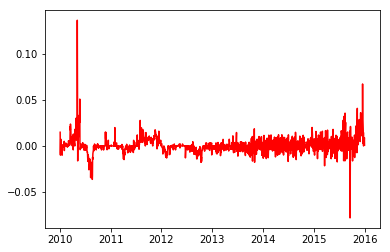

In [61]:
plt.plot(df['Return'],'r')
plt.savefig('Results/plot.png',dpi=2000)

Autocorrelation

In [62]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

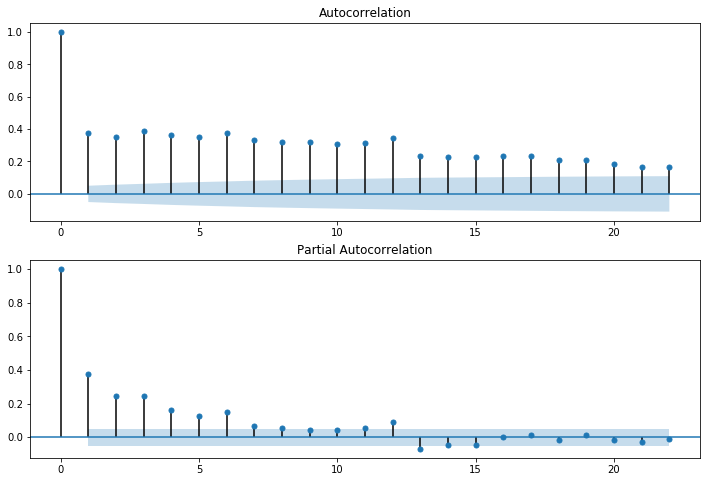

In [63]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['Return'].dropna(),lags=22,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['Return'].dropna(),lags=22,ax=ax2)
fig.savefig('Results/acf22.png',dpi=2000)

Model statistics

In [13]:
import statsmodels.api as sm

D:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [14]:
model = statsmodels.tsa.arima_model.ARIMA(df['Return'],order=(0,1,1))
res = model.fit(maxiter=1000)

Str_conclusion = str(res.summary())
with open("Results/ARMA_summary.txt", "w") as text_file:
        print(Str_conclusion, file=text_file)
Str_conclusion

'                             ARIMA Model Results                              \n==============================================================================\nDep. Variable:               D.Return   No. Observations:                 1514\nModel:                 ARIMA(0, 1, 1)   Log Likelihood                5282.245\nMethod:                       css-mle   S.D. of innovations              0.007\nDate:                Sun, 12 Nov 2017   AIC                         -10558.491\nTime:                        11:38:44   BIC                         -10542.523\nSample:                    01-05-2010   HQIC                        -10552.545\n                         - 12-31-2015                                         \n==================================================================================\n                     coef    std err          z      P>|z|      [0.025      0.975]\n----------------------------------------------------------------------------------\nconst            7.65e-06  

Model Diagnostic

In [65]:
from statsmodels.stats.diagnostic import acorr_ljungbox as LB

In [66]:
result = [pd.Series(range(1,11)),pd.Series(LB(res.resid,lags=10)[0])]
Lbt = pd.concat(result,axis=1)
Lbt.columns=['lags','Test Result']

In [67]:
Lbt.to_excel('Results/Ljung-Box Test.xls')

In [68]:
from statsmodels.stats.stattools import jarque_bera as JB

In [69]:
result = JB(res.resid)
JBResult = 'Jarque-Bera: '+ str(result[0])+'\n p-value:' + str(result[1])+'\n Skewness:' + str(result[2])+'\n Kurtosis:' + str(result[3])
with open("Results/Jarque-Bera.txt", "w") as text_file:
        print(JBResult, file=text_file)

Forecast

Use p=1, q=1

In [7]:
first_day = 0
forecast_day = len(df)
forecast = []
df = df.append(df_forecast)
last_day = len(df_forecast)

In [10]:
import statsmodels.api
for i in range(0,last_day):
    in_sample = df.iloc[first_day:forecast_day-1].dropna()
    model = statsmodels.tsa.arima_model.ARIMA(in_sample['Return'],order=(1,0,1))
    res = model.fit(maxiter=1000)
    fore = res.forecast(1)[0][0]
    forecast.append(fore)
    first_day = first_day+1
    forecast_day = forecast_day+1

D:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [11]:
forecast_data = pd.Series(data=forecast,index=df_forecast.index)
df_forecast = pd.concat([df_forecast,forecast_data],axis=1)

In [15]:
df_forecast.columns=['Rate','Return','Forecast log']

In [16]:
df_forecast['Forecast ARMA'] = np.exp(df_forecast['Forecast log'])*df_forecast['Rate'].shift(1)
df_forecast['Forecast ARMA'].iloc[0] = np.exp(df_forecast['Forecast log'].iloc[0])*df['Rate'].iloc[-1]
MAE_ARMA = np.average(np.abs(df_forecast['Rate']-df_forecast['Forecast ARMA']))
Sum_Square = (df_forecast['Rate']-df_forecast['Forecast ARMA'])**2
RMSE_ARMA = np.sqrt(np.average(Sum_Square))

In [18]:
df_forecast['Naive'] = df_forecast['Rate'].shift(1)
df_forecast['Naive'].iloc[0] = df['Rate'].iloc[-1]
MAE_naive = np.average(np.abs(df_forecast['Rate']-df_forecast['Naive']))
Sum_Square_naive = (df_forecast['Rate']-df_forecast['Naive'])**2
RMSE_naive = np.sqrt(np.average(Sum_Square_naive))

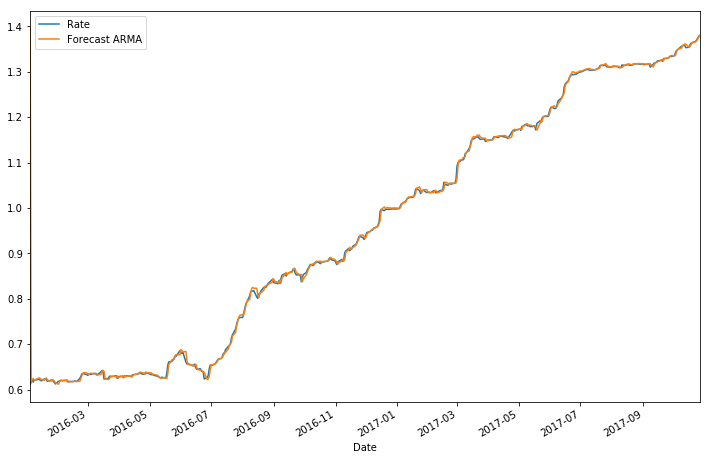

In [19]:
df_forecast[['Rate','Forecast ARMA']].plot(figsize=(12,8))

<h1>ARMA-GARCH

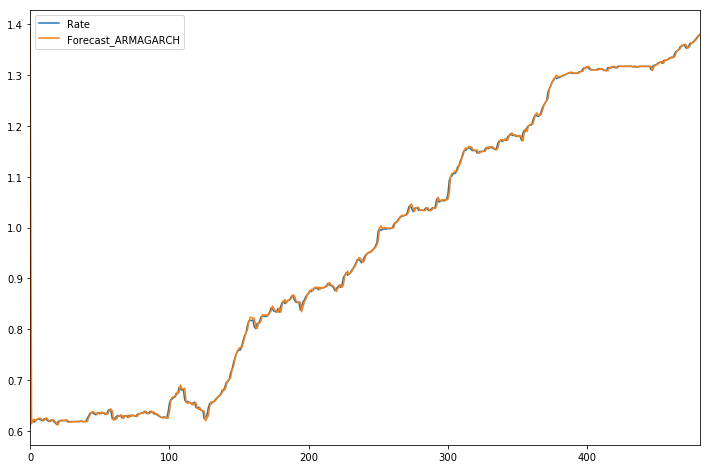

In [20]:
df_armagarch = pd.read_excel('Results\Forecast.xls',index_col='Date')
df_armagarch['Forecast_ARMAGARCH'] = np.exp(df_armagarch['Forecast'])*df_armagarch['Rate'].shift(1)
df_armagarch['Forecast_ARMAGARCH'].iloc[0] = np.exp(df_armagarch['Forecast'].iloc[0])*df['Rate'].iloc[-1]
df_forecast = df_forecast.merge(pd.DataFrame(df_armagarch),how='left')
df_forecast.drop('Forecast',axis=1,inplace=True)
df_forecast.drop('Residuals',axis=1,inplace=True)
df_forecast.to_excel('Results/Prediction 2009 (model 2007-2008).xls')
MAE_ag = np.average(np.abs(df_forecast['Rate']-df_forecast['Forecast_ARMAGARCH']))
Sum_Square_ag = (df_forecast['Rate']-df_forecast['Forecast_ARMAGARCH'])**2
RMSE_ag = np.sqrt(np.average(Sum_Square_ag))
df_forecast[['Rate','Forecast_ARMAGARCH']].plot(figsize=(12,8))

<h1>Forecast Results

In [21]:
title = ['Naive','ARMA','ARMA-Garch']
obs = [str(len(df_forecast)),str(len(df_forecast)),str(len(df_forecast))]
no1 = [RMSE_naive,RMSE_ARMA,RMSE_ag]
no2 = [MAE_naive,MAE_ARMA,MAE_ag]
result = pd.DataFrame(np.transpose([obs,no1,no2]),index=title,columns=['Number of Observations','RMSE','MAE'])
result.to_excel('Results/Forecast_Result.xls')